<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_5_2__Neural_Networks_Basics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Basics 2
## (Dive into Deep Learning https://d2l.ai/chapter_multilayer-perceptrons/index.html)

* The material for this notebook is mainly from the Open Source book -- Dive into Deep Learning. I have adapted a few things for the Computer Vision course at the University of South Florida, Tampa.

* Some figures are from Richard Szeliski's vision textbook for this course.

# Topics covered

* You will learn how to construct the most straightforward classification neural network using softmax operation (activation function). You will also learn about the cross-entropy loss function

* You will learn how to implement a single-layer, softmax-based classification network **using PyTorch** and train it.

* You will learn about multilayer perceptrons, their power over a single layer, and how to implement them in PyTorch. You will also learn about the popular ReLU activation function.

**Concepts learned:** hidden layers, multilayer perceptron, ReLU, Tanh, softmax, activation function, cross-entropy loss function, classification accuracy, PyTorch constructs for deep learning




## Code: setup

In [33]:
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
!pip install d2l==0.16.2 # package for the book - Dive into Deep Learning

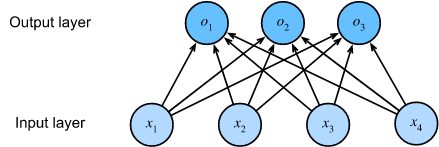

# Fully connected, single-layer, softmax network for classification

* Consider the **classification problem**: given the feature of dimension  $d$, we have to label each data item with one of 3 labels.
    * For example, given a $N \times N$ image, i.e. input dimension $d = N^2$, figure out the state of the light, red, green, or orange.

* The output layer has multiple outputs, one per class.

* Each output is connected to all the inputs. Hence, we have a **fully connected layer**.

\begin{eqnarray}
o_1 &= & x_1 w_{11} + \cdots + x_d w_{1d} + b_1\\
o_2 &= & x_1 w_{21} + \cdots + x_d w_{2d} + b_2\\
\vdots & = &  \vdots \\
o_k &= & x_1 w_{k1} + \cdots + x_d w_{kd} + b_k
\end{eqnarray}


* More compactly, we can use linear algebra notation.

\begin{equation}
\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}
\end{equation}

>* A matrix-vector product of the weights by the input features plus our **biases** $\mathbf{b}$ results in the output.
>* What is the total number of unknown parameters for a fully connected layer with an input of dimension $d$ and $k$ outputs?
>* Also referred to as **logits**

* Note that is an **affine transformation** of the inputs.

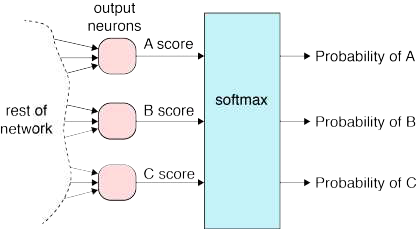

## Softmax operation

* Nothing constrains the output from summing to 1. The outputs can take on negative values too.

* We would like each output to be a probability, i.e., a number between 0 and 1, that denotes the probability of the corresponding label for any given input.
Ideally, only one of the outputs will be near 1, and the rest will be near 0.

* We need to transform this output layer into a final output that is guaranteed (even on new data) to be nonnegative and sum to 1.

* We also need a loss function that encourages the model to estimate probabilities faithfully. Of all instances when a classifier outputs 0.5, we hope that half of those examples will belong to the predicted class.
This is a property called **calibration**.

* The **softmax function**, invented in 1959 by the social scientist R. Duncan Luce in the context of *choice models*, does precisely this.

\begin{equation}
\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{where}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}
\end{equation}

* It is easy to see $\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$
with $0 \leq \hat{y}_j \leq 1$ for all $j$.
Thus, $\hat{\mathbf{y}}$ behaves like a probabilities.

* Note that the softmax operation does not change the ordering among the logits $\mathbf{o}$,
which are simply the pre-softmax values
that determine the probabilities assigned to each class.
Therefore, during prediction, we can still pick out the most likely class by

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

* Although softmax is a nonlinear function, the outputs of softmax regression are still *determined* by an affine transformation of input features;


## Vectorization for mini-batch

* To improve computational efficiency and take advantage of GPUs, we typically carry out vector calculations for mini-batches of data.

* Let  $\mathbf{X}$ be $n \times d$ matrix representing a minibatch of examples with feature dimensionality (number of inputs) $d$ and batch size $n$.

* Then, weights $\mathbf{W}$ is a ${d \times q}$ matrix
and the bias is a ${1\times q}$ vector $\mathbf{b}$.

* The fully connected layer with softmax can compute outputs for **all** inputs in a minibatch **simultaneously** using matrix multiply. No for-loops needed.

\begin{equation}
\begin{aligned} \mathbf{O}^{n \times q} &= \mathbf{X}^{n \times d} \mathbf{W}^{d \times q} + \mathbf{b}^{1\times q}, \\
\hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}
\end{equation}

* [Broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) is triggered during the summation $\mathbf{X} \mathbf{W} + \mathbf{b}$, both the minibatch $\mathbf{O}$ and output probabilities $\hat{\mathbf{Y}}$ are $n \times q$ matrices.



## Loss Function -- Cross entropy


* Squared difference error is not the appropriate error/residual/loss function to optimize. We use an error function that is appropriate for probability distributions -- **cross-entropy**.

* The softmax function gives us a vector $\hat{\mathbf{y}}$, which we can interpret as estimated probabilities of each class given any input $\mathbf{x}$, e.g., $\hat{y}_1$ = $P(y=\text{cat} \mid \mathbf{x})$.

* Suppose that the entire dataset $\{\mathbf{X}, \mathbf{Y}\}$ has $n$ examples,
where the example indexed by $i$ consists of a feature vector $\mathbf{x}^{(i)}$ and a **one-hot label vector** $\mathbf{y}^{(i)}$, i.e., an all-zero vector with one entry equal to 1 corresponding to the position denoting the label.

* We can compare the estimates with labels by checking how probable the actual classes are according to our model, given the features:

\begin{equation}
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
\end{equation}

* According to maximum likelihood estimation,
we maximize $P(\mathbf{Y} \mid \mathbf{X})$,
which is
equivalent to minimizing the negative log-likelihood:

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

> where for any pair of label $\mathbf{y}$ and model prediction $\hat{\mathbf{y}}$ over $q$ classes,
the loss function $l$ is

\begin{equation}
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}


* This loss function is commonly called the **cross-entropy loss**.

* $\mathbf{y}$ is a **one-hot vector** of length $q$
    * so, the sum over all its coordinates $j$ vanishes for all but one term.

* Since all $\hat{y}_j$ are predicted probabilities, their logarithm is never larger than $0$.

* Consequently, the loss function cannot be minimized any further
if we correctly predict the actual label with *certainty*,
i.e., if the predicted probability $P(\mathbf{y} \mid \mathbf{x}) = 1$ for the actual label $\mathbf{y}$.


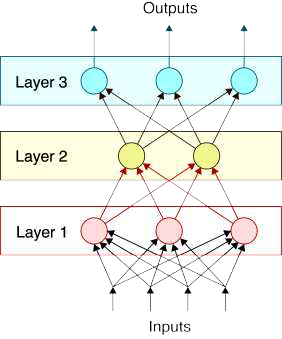

## Summary of Model

* Let  $\mathbf{X}$ be $n \times d$ matrix representing a minibatch of examples with feature dimensionality (number of inputs) $d$ and batch size $n$.

* Then, weights $\mathbf{W}$ is a ${d \times q}$ matrix
and the bias is a ${1\times q}$ vector $\mathbf{b}$.

* The fully connected layer with softmax can compute outputs for **all** inputs in a minibatch **simultaneously** using matrix multiply. No for-loops needed.

\begin{equation}
\begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}
\end{equation}

* This loss function is commonly called the **cross-entropy loss**.


\begin{equation}
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}


## Implementation of softmax regression

* Just as we implemented linear regression from scratch, we believe that softmax regression is similarly fundamental, and you ought to know the gory details of softmax regression and how to implement it yourself.

* We will work with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), setting up a data iterator with batch size 256.


###Code: ReadFashion MSNIST data (`train_iter, test_iter`)

In [34]:
from IPython import display
from d2l import torch as d2l

In [35]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

for X, y in train_iter:
    print('Each element of train_iter has: X=',  X.shape, 'y=', y.shape)
    break

for X, y in test_iter:
    print('Each element of test_iter  has: X=', X.shape, 'y=', y.shape)

    print(' We will reshape X before use into =', X.reshape((-1, 784)).shape)
    break


Each element of train_iter has: X= torch.Size([256, 1, 28, 28]) y= torch.Size([256])
Each element of test_iter  has: X= torch.Size([256, 1, 28, 28]) y= torch.Size([256])
 We will reshape X before use into = torch.Size([256, 784])


## Defining the fully connected (FC) layer

* As in our linear regression example, each example here will be represented by a fixed-length vector. Each example in the raw dataset is a $28 \times 28$ image. In this section, **we will flatten each image, treating them as vectors of length 784.** In the future, we will talk about more sophisticated strategies for exploiting the spatial structure in images, but for now, we treat each pixel location as just another feature.

* Recall that in softmax regression, we have as many outputs as there are classes. **Because our dataset has 10 classes, our network will have an output dimension of 10.** Consequently, our weights will constitute a $784 \times 10$ matrix and the biases will constitute a $1 \times 10$ row vector. As with linear regression, we will initialize our weights `W` with Gaussian noise and our biases to take the initial value 0.


### Code: Fully connected (FC) layer (`W, b`)

In [36]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

print('W shape is', W.shape, '\nW=', W)
print('\nb shape is', b.shape, '\nb=', b)

W shape is torch.Size([784, 10]) 
W= tensor([[-1.5467e-02, -8.0168e-03,  1.0170e-03,  ..., -5.7202e-03,
         -4.7569e-03,  7.4411e-03],
        [-2.1166e-02,  1.8077e-02,  1.2888e-02,  ..., -4.6347e-03,
         -1.1745e-02,  4.5286e-03],
        [ 1.0655e-02,  7.2778e-03, -2.2223e-03,  ...,  5.1738e-03,
          1.5890e-02,  6.3333e-03],
        ...,
        [ 5.5302e-03,  2.2989e-02,  9.3206e-05,  ...,  1.2367e-02,
          8.1763e-03,  8.5530e-03],
        [-5.9632e-03, -7.8825e-03,  1.5932e-02,  ...,  1.2279e-02,
         -4.4936e-03, -2.9941e-03],
        [-3.7301e-03, -1.7015e-02,  2.2339e-02,  ...,  8.7181e-03,
         -1.7940e-03,  1.8971e-03]], requires_grad=True)

b shape is torch.Size([10]) 
b= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


## Defining the softmax operation

* Before implementing the softmax regression model, let us briefly review how the sum operator works along specific dimensions in a tensor. **Given a matrix `X`, we can sum over all elements (by default) or only over elements in the same axis,**, i.e., the same column (axis 0) or the same row (axis 1).

* When invoking the sum operator, we can specify to keep the number of axes in the original tensor rather than collapsing out the dimension that we summed over. The result is a two-dimensional tensor with shape (1, 3).

* Note that if `X` is a tensor with shape (2, 3) and we sum over the columns, the result will be a vector with shape (3,).


In [37]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print('X, sum over dim 0\n', X.sum(0, keepdim=False))
print('\nX, sum over dim 1\n', X.sum(0, keepdim=True))

X, sum over dim 0
 tensor([5., 7., 9.])

X, sum over dim 1
 tensor([[5., 7., 9.]])


* We are now ready to **implement the softmax operation**. Recall that softmax consists of three steps:
    1. We exponentiate each term (using `exp`)
    2. we sum over each row (we have one row per example in the batch) to get the normalization constant for each example
    3. We divide each row by its normalization constant, ensuring that the result sums it to 1.

* Before looking at the code, let us recall how this looks expressed as an equation. We are processing one minibatch at a time, so $\mathbf{O}_{ij}$ is `batch_size` $\times$ `output_dim` matrix, whose rows store the output vector for the corresponding training sample in the minibatch.

\begin{equation}
\mathrm{softmax}(\mathbf{O})_{ij} = \frac{\exp(\mathbf{O}_{ij})}{\sum_k \exp(\mathbf{O}_{ik})}
\end{equation}

* (Advanced Material:) The denominator, or normalization constant, is sometimes called the **partition function** (its logarithm is called the log-partition function). The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics)), where a related equation models the distribution over an ensemble of particles.


### Code: Softmax layer (`softmax`)

In [38]:
def softmax(Oh):
    Oh_exp = torch.exp(Oh)
    partition = Oh_exp.sum(1, keepdim=True)
    return Oh_exp / partition  # The broadcasting mechanism is applied here

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability measure.


In [39]:
Oh = torch.normal(0, 1, (2, 5))
Y_prob = softmax(Oh)
print('Oh =\n', Oh)
print('Y_prob =\n', Y_prob, '\nSum=', Y_prob.sum(1))

Oh =
 tensor([[-1.2610,  0.4333,  0.1567, -1.0744,  1.6394],
        [ 0.6141,  1.1767, -1.2274, -0.2412, -0.2176]])
Y_prob =
 tensor([[0.0334, 0.1817, 0.1378, 0.0402, 0.6069],
        [0.2650, 0.4651, 0.0420, 0.1126, 0.1153]]) 
Sum= tensor([1.0000, 1.0000])


## Putting together the Model

Now that we have defined the softmax operation, we can **implement the softmax regression model.** The below code implements how the input is mapped to the output through the network. Note that we flatten each original image in the batch into a vector using the `reshape` function before passing the data through our model.


###Code: Model (`net`)

In [40]:
def net(X):
    # X dimension is [256, 1, 28, 28] which we reshape into [256, 784]
    # size of W is [784 10]
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


## Defining the cross-entropy loss function

* Recall that cross-entropy takes the negative log-likelihood of the predicted probability assigned to the true label. We can pick all elements by a single operator rather than iterating over the predictions with a Python for-loop (which tends to be inefficient).

* Below, we **create sample data `y_hat` with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**

* With `y`, we know that in the first example, the first class is the correct prediction, and in the second example, the third class is the ground truth.
**Using `y` as the indices of the probabilities in `y_hat`,** we pick the probability of the first class in the first example and the probability of the third class in the second example.


In [41]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6],
                      [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Now we can **implement the cross-entropy loss function** efficiently with just one line of code.


### Code: `cross_entropy_loss`

In [42]:
def cross_entropy_loss (y_hat, y):

    return -torch.log(y_hat[range(len(y_hat)), y])
    #range(len(y_hat)) creates indices 0,1,2,len-1

cross_entropy_loss (y_hat, y)


tensor([2.3026, 0.6931])

## Classification Accuracy

* Given the predicted probability distribution `y_hat`, we typically choose the class with the highest predicted probability whenever we must output a hard prediction.

    * Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums". It might estimate probabilities internally, but it has to choose one among the classes at the end of the day.

* The classification accuracy is the fraction of all correct predictions. Although it can be challenging to optimize accuracy directly (it is not differentiable), it is often the performance measure we care most about, and we will nearly always report it when training classifiers.

* To compute accuracy, we do the following.
    1. If `y_hat` is a matrix, we assume that the second dimension stores prediction scores for each class. We use `argmax` to obtain the predicted class by the index for the largest entry in each row.
    2. We **compare the predicted class with the ground-truth `y` elementwise.** Since the equality operator `==` is sensitive to data types, we convert `y_hat`'s data type to match that of `y`. The result is a tensor containing 0 (false) and 1 (true) entries. Taking the sum yields the number of correct predictions.


In [43]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: #The output is a vector -- not just a scalar
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

We will continue to use the variables `y_hat` and `y`
defined before
as the predicted probability distributions and labels, respectively.
We can see that the first example's prediction class is 2
(the largest element of the row is 0.6 with the index 2),
which is inconsistent with the actual label, 0.
The second example's prediction class is 2
(the largest element of the row is 0.5 with the index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.


In [44]:
accuracy(y_hat, y) / len(y)

0.5

**Similarly, we can evaluate the accuracy for any model `net` on a dataset** that is accessed via the data iterator `data_iter`.


###Code: `evaluate_accuracy`

In [45]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter: # iterate over the minibatches
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

* Here `Accumulator` is a utility class to accumulate sums over multiple variables.

* In the above `evaluate_accuracy` function, we create 2 variables in the `Accumulator` instance to store the number of correct predictions and the number of predictions, respectively.

* We  will accumulate both over time as we iterate over the dataset.


In [46]:
[0.0] * 4

[0.0, 0.0, 0.0, 0.0]

In [47]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # creates [0.0, 0.0, ....n-times]

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # Example: let self.data = [10, 15] and args be [3, 4]
        # zip(self.data, args) will produce the paired iterable [(10, 3), (15, 4)]
        # the for loop with go over these paired entries adding them up to result in [13, 19]

    def reset(self):
        self.data = [0.0] * len(self.data) # creates [0.0, 0.0, ....n-times]

    def __getitem__(self, idx):
        return self.data[idx]

**Because we initialized the `net` model with random weights, the accuracy of this model should be close to random guessing,** i.e., 0.1 for 10 classes.


In [48]:
evaluate_accuracy(net, test_iter)

0.1408

## Training

* The training loop for softmax regression should look strikingly familiar to the implementation of linear regression.

* Here, we refactor the implementation to make it reusable. First, we define a function to train for one epoch. Note that `updater` is a general function to update the model parameters, which accepts the batch size as an argument.
It can be either a wrapper of the `d2l.sgd` function or a framework's built-in optimization function.


### Code: `train_one_epoch`

In [49]:
def stochastic_gradient_descent (params, lr):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

In [50]:
def my_updater ():
    return stochastic_gradient_descent([W, b], lr)

# we use the minibatch stochastic gradient descent we wrote earlier to
# optimize the loss function of the model

In [51]:
def train_one_epoch (net, train_iter, loss, updater):

    metric = Accumulator(3) # Sum of training loss, sum of training accuracy, no. of examples
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        l.mean().backward()
        updater()
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function,
we define **a utility class that plot data in animation.**

###Code: `Animator` class

In [52]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

* The following function trains a model `net` on a training dataset accessed via `train_iter` for multiple epochs, which is specified by `num_epochs`.

* At the end of each epoch, the model is evaluated on a test dataset accessed via `test_iter`.

* We will leverage the `Animator` class to visualize the training progress.


###Code: `train_full`

In [53]:
def train_full (net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_one_epoch (net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    return (train_loss, train_acc, test_acc)

Now we **train the model with 10 epochs.** Note that both the number of epochs (`num_epochs`), and learning rate (`lr`) are adjustable hyperparameters. By changing their values, we may be able to increase the classification accuracy of the model.


### Code: Run train

(0.44720842831929525, 0.8485666666666667, 0.8294)

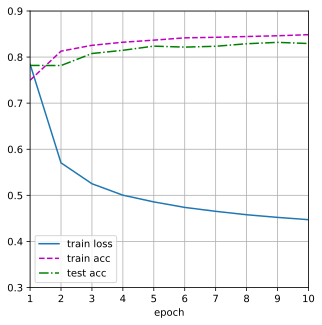

In [54]:
num_epochs = 10
lr = 0.1
train_full (net, train_iter, test_iter, cross_entropy_loss, num_epochs, my_updater)

## Prediction

Now that training is complete, our model is ready to **classify some images.**
Given a series of images, we will compare their actual labels (first line of text output) and the predictions from the model (second line of text output).


### Code: `predict`

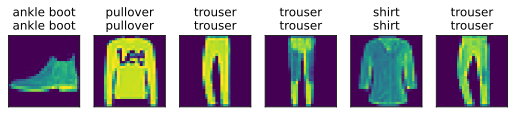

In [55]:
def predict (net, test_iter, n=6):
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1)) ## This is how you invoke the model
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict (net, test_iter)

## Summary

* With softmax regression, we can train models for multiclass classification.
* The training loop of softmax regression is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.



# Assignment

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause? Hint: Try calculating the size of $\exp(50)$.
1. The function `cross_entropy` in this section was implemented according to the definition of the cross-entropy loss function. What could be the problem with this implementation? Hint: consider the domain of the logarithm.
1. What solutions can you consider to fix the two problems above?
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?


# Model Single Layer - Softmax

* Let  $\mathbf{X}$ be $n \times d$ matrix representing a minibatch of examples with feature dimensionality (number of inputs) $d$ and batch size $n$.

* Weights are captured in a $\mathbf{W}$ is a ${d \times q}$ matrix
and the bias is a ${1\times q}$ vector $\mathbf{b}$.

* The fully connected layer with softmax can compute outputs for **all** inputs in a minibatch **simultaneously** using matrix multiply. No for-loops needed.

\begin{eqnarray}
\mathbf{O} & = &\mathbf{X} \mathbf{W} + \mathbf{b} \\
\hat{\mathbf{Y}} & = &\mathrm{softmax}(\mathbf{O}) \\
\end{eqnarray}


* This loss function is commonly called the **cross-entropy loss**.


\begin{equation}
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}


## Code: Initializing Model Parameters: `linear_net`

* To implement our softmax-linear model, we just need to add one fully-connected layer with 10 outputs.
    * https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html -- the input is passed on from one to the next in a sequential fashion
    * https://pytorch.org/docs/stable/generated/torch.flatten.html?highlight=flatten#torch.flatten -- returns the same object most of the time, not a copy.
    * https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear

* We initialize the weights at random
with zero mean and standard deviation 0.01.
    * https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=apply#torch.nn.Module.apply


In [56]:
# PyTorch does not implicitly reshape the inputs. Thus we define the flatten
# layer to reshape the inputs before the linear layer in our network
linear_net = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(784, 10)
                    )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

linear_net.apply(init_weights)
print(linear_net)

total_params = sum(p.numel() for p in linear_net.parameters() if p.requires_grad)

print('\n Total parameters:', total_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

 Total parameters: 7850


## Code: Cross entropy loss: `loss`


* Cross-entropy loss

\begin{equation}
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}

* We can combine Softmax and Cross-entropy Loss in one single operation, saving on some computation complexity.

* Even though softmax involves exponential computing functions, we ultimately intend to take their log when calculating the cross-entropy loss.


* We can combine softmax and cross-entropy

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j)}{\sum_k \exp(o_k)}\right) \\
& = \log{(\exp(o_j))}-\log{\left( \sum_k \exp(o_k) \right)} \\
& = o_j  -\log{\left( \sum_k \exp(o_k) \right)}.
\end{aligned}
$$

* Instead of passing softmax probabilities into our new loss function, we will **pass the logits ($o_j$) and compute the softmax and its log all at once inside the cross-entropy loss function,**

\begin{equation}
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j o_j +  \log{\left( \sum_k \exp(o_k) \right) \sum_{j=1}^q y_j}
\end{equation}


* We will want to keep the conventional softmax function handy if we ever want to evaluate the output probabilities by our model.

* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss

In [57]:
loss = nn.CrossEntropyLoss()

## Code: Optimization Algorithm: `trainer`

* Here, we **use minibatch stochastic gradient descent** with a learning rate of 0.1 as the optimization algorithm. Note that this is the same as we applied in the linear regression example, illustrating the optimizers' general applicability.


In [58]:
trainer = torch.optim.SGD(linear_net.parameters(), lr=0.1)

## Code: Training



In [59]:
#-------------------------------------------------------------------------------
def train_one_epoch (net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)

        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.backward()
        updater.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

#-------------------------------------------------------------------------------
def train_full (net, train_iter, test_iter, loss, num_epochs, updater):

    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        train_metrics = train_one_epoch (net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)

        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    return (train_loss, train_acc, test_acc)

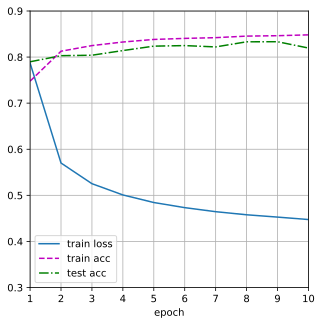

In [60]:
num_epochs = 10

train_full (linear_net, train_iter, test_iter, loss, num_epochs, trainer);

As before, this algorithm converges to a solution
that achieves a decent accuracy,
albeit this time with fewer lines of code than before.


## Summary

* For cross-entropy loss, softmax regression can be combined with cross-entropy loss to save some computational time.

* Note that in many cases, a deep learning framework takes  precautions beyond these most well-known tricks to ensure numerical stability, saving us from even more pitfalls that we would encounter if we tried to code all of our models from scratch in practice.

# Assignment

1. Vary the hyperparameters as follows and document the loss, accuracy on train set, accurarcy on test set.

    batch sizes (batch_size): 256, 128, 64

    number of epochs (num_epochs): 10, 20, 30

    learning rate (lr): 0.1, 0.01, 0.2

2. Comment on the learning behavior observed.


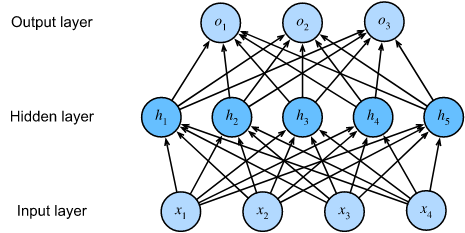

# Multilayer Perceptrons



## Hidden Layers -- just stacking is not enough

* If our labels indeed were related to our input data by an affine transformation, then our earlier linear-softmax approach would be sufficient. However, an affine transformation is a *strong* assumption.

* We can overcome these limitations of linear models and handle a more general class of functions by incorporating one or more **hidden layers**.

* The easiest way to do this is to stack **many fully-connected layers** on top of each other. Each layer feeds into the layer above it until we generate outputs.

* We can think of the first $L-1$ layers as our representation and the final layer as our linear predictor. This architecture is commonly called a **multilayer perceptron**, often abbreviated as *MLP*.

* In the example above, the MLP has 4 inputs, 3 outputs, and its hidden layer contains 5 hidden units.

* Since the input layer does not involve any calculations, producing outputs with this network requires implementing the computations for both the hidden and output layers; thus, the number of layers in this MLP is 2.

*  Note that these layers are both fully connected. Every input influences every neuron in the hidden layer, and each of these, in turn, influences
every neuron in the output layer.

* However, the parameterization cost of MLPs with fully connected layers
can be prohibitively high, which may motivate a tradeoff between parameter saving and model effectiveness even without changing the input or output size.

* Note that our model now requires us to track and update additional parameters after adding the hidden layer. So what have we gained in exchange? You might be surprised to discover that---in the model defined above---*we gain nothing for our troubles*!

* **Two affine transforms following each other result in another affine transform! (Can you mathematically show this?) So the many layers can be adequately modeled using one layer!**

    * The operations of the two layers can be represented by

    \begin{equation}
    \begin{aligned}
        \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
        \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
    \end{aligned}
    \end{equation}

    * We can view the equivalence formally by proving that for any values of the weights, we can collapse out the hidden layer, yielding an equivalent single-layer model with parameters $\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

    \begin{eqnarray}
    \mathbf{O} & = & (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    & = & \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    & = & \mathbf{X} \mathbf{W} + \mathbf{b}.
    \end{eqnarray}



## From Linear to Nonlinear

* We need one more key ingredient: **a nonlinear activation function** $\sigma$ to be applied to each hidden unit following the affine transformation.

* The outputs of activation functions (e.g., $\sigma(\cdot)$) are called *activations*. In general, with activation functions in place, it is no longer possible to collapse our MLP into a linear model:

\begin{eqnarray}
\mathbf{H} & = & \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}),\\
\mathbf{O} & = & \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{eqnarray}

* To build more general MLPs, we can continue stacking such hidden layers, e.g., $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
and $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$, one atop another, yielding ever more expressive models.


* Universal Approximators

    * Moreover, for certain choices of the activation function, it is widely known that MLPs are universal approximators.

    * Even with a single-hidden-layer network, given enough nodes (possibly absurdly many), and the right set of weights, we can model any function, though learning that function is the hard part.

    * Moreover, just because a single-hidden-layer network *can* learn any function does not mean that you should try to solve all of your problems with single-hidden-layer networks.

    * In fact, we can approximate many functions much more compactly by using deeper (vs. wider) networks. We will touch upon more rigorous arguments in subsequent chapters.





## Activation Functions

Activation functions decide whether a neuron should be activated by calculating the weighted sum and adding bias. They are differentiable operators to transform input signals into outputs, while most add non-linearity. Because activation functions are fundamental to deep learning, **let us briefly survey some common activation functions**.

### ReLU Function

* The most popular choice, due to both simplicity of implementation and its good performance on various predictive tasks, is the *rectified linear unit* (*ReLU*). **ReLU provides a straightforward nonlinear transformation**.

* Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

* Informally, the ReLU function retains only positive elements and discards all harmful elements by setting the corresponding activations to 0. To gain some intuition, we can plot the function. As you can see, the activation function is piecewise linear.


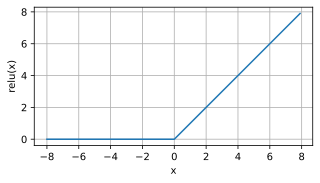

In [61]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

* **Derivative** of RELU: Mathematically, the function does not have a derivative at x=0, but in practice, we ignore it and assign a zero derivative value for x=0.

* Note that the derivative is either zero or positive. **Operationally, when we chain derivatives together during an update, this layer will stop derivatives from passing through if the value is negative.** The derivative will not propagate down if the node's value is negative.


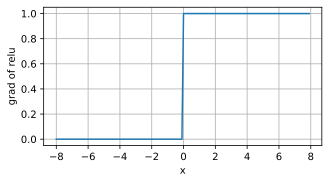

In [62]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))


### Sigmoid Function

* **The *sigmoid function* transforms its inputs to outputs that lie on the interval (0, 1).**

* For that reason, the sigmoid is often called a *squashing function*: it squashes any input in the range (-inf, inf) to some value in the range (0, 1):

\begin{equation}
\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}
\end{equation}

* In the earliest neural networks, scientists were interested in modeling biological neurons that either *fire* or *do not fire*. Thus the pioneers of this field, going back to McCulloch and Pitts, the inventors of the artificial neuron, focused on thresholding units.
    * A thresholding activation takes value 0 when its input is below some threshold and 1 when the input exceeds the threshold.

* When attention shifted to gradient-based learning, the sigmoid function was a natural choice because it is a smooth, differentiable approximation to a thresholding unit.

* Sigmoids are still widely used as activation functions on the output units when we interpret the outputs as probabilities for binary classification problems (you can think of the sigmoid as a particular case of the softmax, just for one node).

* However, the sigmoid has mostly been replaced by the simpler and more easily trainable ReLU for most use in hidden layers.

* Below, we plot the sigmoid function. Note that when the input is close to 0,
the sigmoid function approaches a linear transformation.


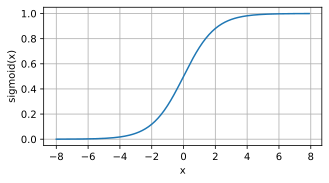

In [63]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

* The **derivative** of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


* The derivative of the sigmoid function is plotted below. Note that when the input is 0, the derivative of the sigmoid function reaches a maximum of 0.25.
As the input diverges from 0 in either direction, the derivative approaches 0.


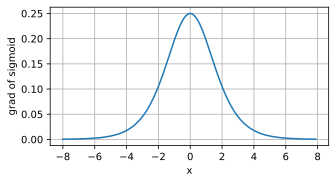

In [64]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Tanh Function

* Like the sigmoid function, **the tanh (hyperbolic tangent) function also squashes its inputs**, transforming them into elements on the interval (**between -1 and 1**):

\begin{equation}
\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}
\end{equation}

* We plot the tanh function below. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.


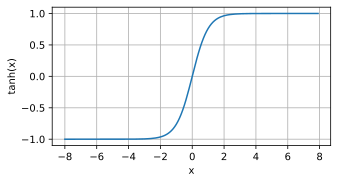

In [65]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

* The **derivative** of the tanh function is:

\begin{equation}
\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x)
\end{equation}

* The derivative of tanh function is plotted below. As the input nears 0, the derivative of the tanh function approaches a maximum of 1. And as we saw with the sigmoid function, as the input moves away from 0 in either direction, the derivative of the tanh function approaches 0.


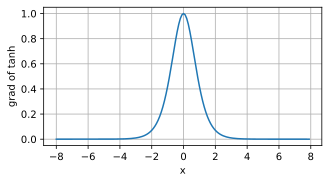

In [66]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## Summary

* MLP adds one or multiple fully-connected hidden layers between the output and input layers and transforms the output of the hidden layer via an activation function.

* Commonly-used activation functions include the ReLU function, the sigmoid function, and the tanh function.


## Code: Model

* We add *two* fully-connected layers (previously, we added *one*). The first is [**our hidden layer**], which (**contains 256 hidden units and applies the ReLU activation function**). The second is our output layer.


In [67]:
mlp_net = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10)
                    )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

mlp_net.apply(init_weights);
print(mlp_net)


total_params = sum(p.numel() for p in mlp_net.parameters() if p.requires_grad)
print('\n Total parameters:', total_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

 Total parameters: 203530


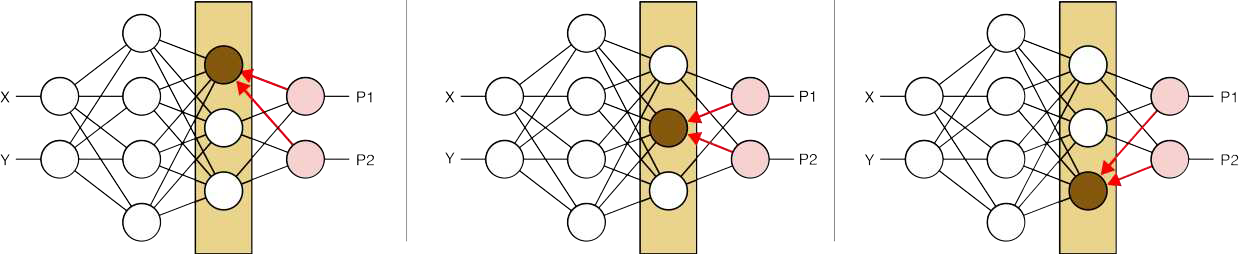

**Backpropagating** the derivatives (errors) through an intermediate layer of the deep network (© Glassner (2018). The derivatives of the loss function applied to a single training example with respect to each of the pink unit inputs are summed together and the process is repeated chaining backward through the network.

## Code: Training
**The training loop** is exactly the same as when we implemented softmax regression. This modularity enables us to separate matters concerning the model architecture from operations on it.


In [68]:
batch_size, lr, num_epochs = 256, 0.03, 30
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(mlp_net.parameters(), lr=lr) # network used here...

(0.38657334326108295, 0.8664, 0.8486)

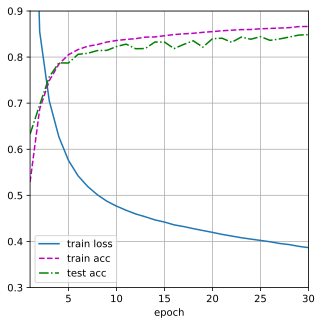

In [69]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_full (mlp_net, train_iter, test_iter, loss, num_epochs, trainer)

## Prediction

Now that training is complete, our model is ready **to classify some images.**
Given a series of images, we will compare their actual labels (first line of text output) and the predictions from the model (second line of text output).


## Code: `predict`

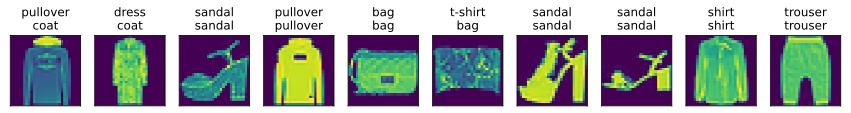

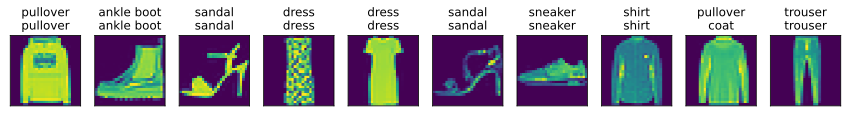

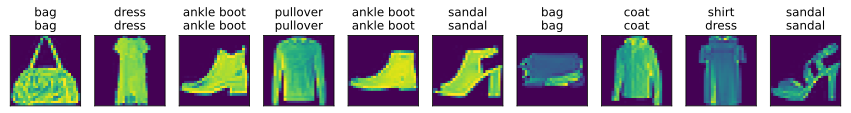

In [70]:
def predict (net, test_iter, n=10):

    X, y = next(iter(train_iter))

    #for X, y in test_iter:
    #    break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1)) ## This is how you invoke the model
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict (mlp_net, test_iter)
predict (mlp_net, test_iter)
predict (mlp_net, test_iter)